Accelerating portable HPC Applications with Standard C++
===

# Lab 2: 2D Unsteady Heat Equation

In this tutorial we will take a pre-existing MPI mini-application and parallelize it using the C++ parallel algorithms to obtain an "hybrid" mini-application - hybrid as in MPI & C++ - that runs on multiple nodes using multiple CPU cores or one GPU per rank. 

A working implementation using only MPI is provided in [starting_point.cpp].

[starting_point.cpp]: ./starting_point.cpp

## Getting started

Let's start by compiling and running the starting point:


In [1]:
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -march=native -o heat starting_point.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 5.16074 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 10.3215 GB/s


### Selecting a compiler

Here we use the `OMPI_CXX` environment variable preceding the `mpicxx` command to pick the C++ compiler, e.g., `OMPI_CXX=g++` picks the GNU g++ compiler.

### Number of ranks

**PLEASE** be mindful when using the notebooks through one of the systems we provide during the tutorials.
These systems are often shared by many students and increasing the number of ranks worsens the experience for everybody.

Having said that, feel free to increase the number of ranks when running the tutorial on your own system :)

### Program Command Line Interface

* `./heat 1024 1024 4000`: runs the heat-equation mini-application; it takes three arguments: `NX NY NITERATIONS`
  * `NX` and `NY`: number of unknown per MPI rank in `x` and `y` dimensions
  * `NITERATIONS`: number of time-step to simulate
  
### Performance results

This mini-application performs a "weak scaling": `NX` and `NY` control the number of unknowns per MPI rank, such that NX=256 NY=256 results in a grid size of 256x256 nodes per rank. When running the application with, e.g., two ranks, the size of the whole grid doubles to 512x256 along the NX dimension (the NY dimension is kept constant).

The performance results show two memory BWs: the memory BW delivered by 1 rank, and by all ranks.
  
### Visualizing the results

The `heat` binary writes a solution to an `output` file, that can be converted to a png file using the `vis` script or the following function:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#plt.style.use('dark_background') # Uncomment for dark background

def visualize(name = 'output'):
    f = open(name, 'rb')
    grid = np.fromfile(f, dtype=np.uint64, count=2, offset=0)

    nx = grid[0]
    ny = grid[1]

    times = np.fromfile(f, dtype=np.float64, count=1, offset=0)
    time = times[0]

    values = np.fromfile(f, dtype=np.float64, offset=0)
    assert len(values) == nx * ny, f'{len(values)} != {nx * ny}'
    values = values.reshape((nx, ny))

    print(f'Plotting grid {nx}x{ny}, t = {time}')

    plt.title(f'Temperature at t = {time:.3f} [s]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.pcolormesh(values, cmap=plt.cm.jet, vmin=0, vmax=values.max())
    plt.colorbar()
    plt.savefig('output.png', transparent=True, bbox_inches='tight', dpi=300)

Plotting grid 512x256, t = 0.048828125


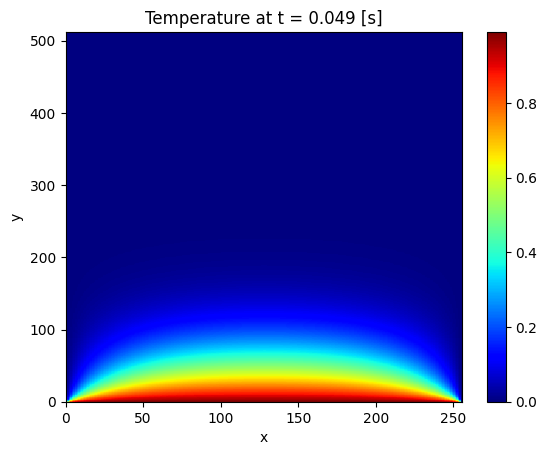

In [3]:
visualize()

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 2.50168 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 5.00336 GB/s
Plotting grid 512x256, t = 0.048828125


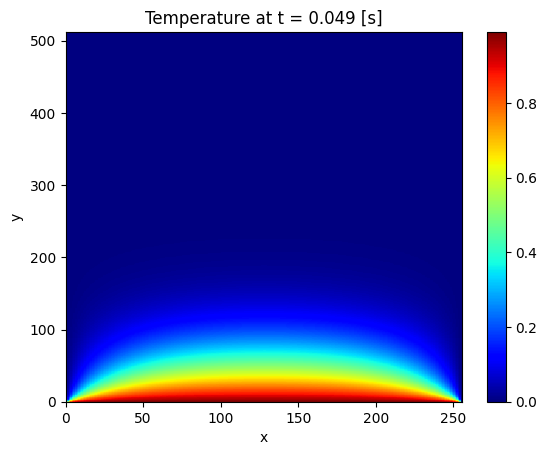

In [4]:
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -march=native -o heat starting_point.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 7.10953 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 14.2191 GB/s
Plotting grid 512x256, t = 0.048828125


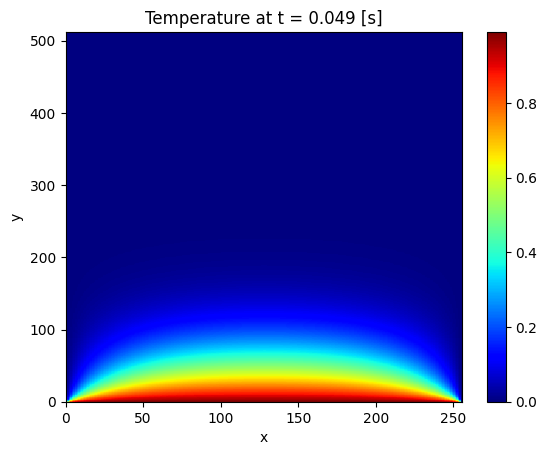

In [5]:
!OMPI_CXX=nvc++ mpicxx -std=c++20 -O4 -fast -march=native -Mllvm-fast -o heat starting_point.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

## Exercise 1: Parallelize with C++ parallel algorithms

The goal of this exercise is to parallelize the `stencil` and `initialize` implementations using the C++ parallel algorithms.

A template for the solution is provided in [exercise1.cpp].
The only functions that needs to be modified to achieve this are the `stencil` and `initial_condition` functions.

In the serial implementation, raw loops are used:

```c++
#include <cartesian_product.hpp> // Brings C++23 std::views::cartesian_product to C++20
// TODO: add C++ standard library includes as necessary
// #include <...>

double stencil(double* u_new, double* u_old, grid g, parameters p) {
  // TODO: implement using parallel algorithms
  double energy = 0.;
  for (long x = g.x_begin; x < g.x_end; ++x) {
    for (long y = g.y_begin; y < g.y_end; ++y) {
      energy += stencil(u_new, u_old, x, y, p);
    }
  }
  return energy;
}
```

Parallelize it using the C++ parallel algorithms by:
* Using `std::views::cartesian_product` to create a range ([documentation](https://en.cppreference.com/w/cpp/ranges/cartesian_product_view)).
* Using the `std::transform_reduce` algorithm (overload 3 from the [documentation](https://en.cppreference.com/w/cpp/algorithm/transform_reduce)).

While `std::views::cartesian_product` is part of C++23, most C++ toolchains do not provide an implementation of it yet.
For this tutorial, we provide a single header implementation of `cartesian_product` that is backported to C++20.
The exercise templates include it for you via: 

```c++
#include <cartesian_product.hpp> // Brings C++23 std::views::cartesian_product to C++20
```

Once C++23 support includes it, you'll automatically get it via the `<ranges>` include.

To keep all memory on the device when offloading the C++ parallel algorithms, also parallelize the `initial_condition` function from its raw loop version using the `std::fill_n` ([documentation](https://en.cppreference.com/w/cpp/algorithm/fill_n)) parallel algorithm:

```c++
void initial_condition(double* u_new, double* u_old, long n) {
  // TODO: implement using parallel algorithms
  for (long i = 0; i < n; ++i) {
    u_old[i] = 0.;
    u_new[i] = 0.;
  }
}
```

### Compilation and run commands

[exercise1.cpp]: ./exercise1.cpp

While [exercise1.cpp] compiles and runs as provided, it produces incorrect results due to the incomplete `stencil` and `initialize` implementations.
Search for `TODO`s in the file and fix them until your compiler of choice compiles and run correctly:


E(t=0) = 0
E(t=0.00305176) = 0
E(t=0.00610352) = 0
E(t=0.00915527) = 0
E(t=0.012207) = 0
E(t=0.0152588) = 0
E(t=0.0183105) = 0
E(t=0.0213623) = 0
E(t=0.0244141) = 0
E(t=0.0274658) = 0
E(t=0.0305176) = 0
E(t=0.0335693) = 0
E(t=0.0366211) = 0
E(t=0.0396729) = 0
E(t=0.0427246) = 0
E(t=0.0457764) = 0
Rank 0: local domain 256x256 (0.00104858 GB): 399.309 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 798.618 GB/s
Plotting grid 512x256, t = 0.048828125


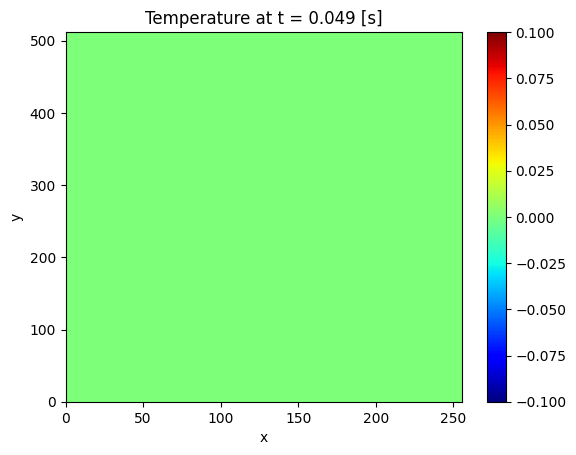

In [6]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -march=native -o heat exercise1.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

E(t=0) = 0
E(t=0.00305176) = 0
E(t=0.00610352) = 0
E(t=0.00915527) = 0
E(t=0.012207) = 0
E(t=0.0152588) = 0
E(t=0.0183105) = 0
E(t=0.0213623) = 0
E(t=0.0244141) = 0
E(t=0.0274658) = 0
E(t=0.0305176) = 0
E(t=0.0335693) = 0
E(t=0.0366211) = 0
E(t=0.0396729) = 0
E(t=0.0427246) = 0
E(t=0.0457764) = 0
Rank 0: local domain 256x256 (0.00104858 GB): 499.073 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 998.145 GB/s
Plotting grid 512x256, t = 0.048828125


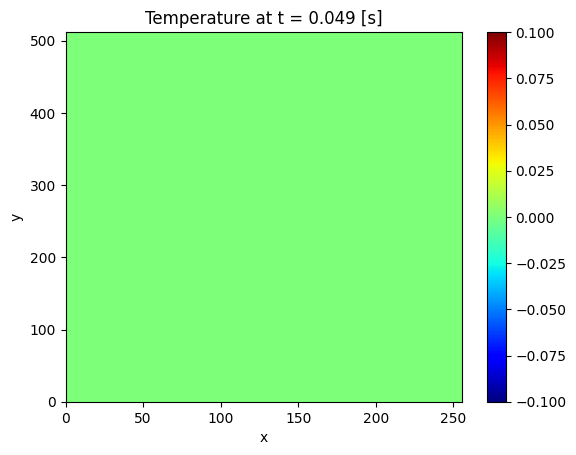

In [7]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -march=native -o heat exercise1.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

### Solutions Exercise 1

The solution for this exercise is in [`solutions/exercise1.cpp`].

[`solutions/exercise1.cpp`]: ./solutions/exercise0.cpp

The following compiles and runs the solutions for Exercise 1 using different compilers.

**NOTE**: The problem size used here is too small to benefit from GPU acceleration. Try with a problem that's 1GB large, like using the following CLI arguments `65536 128 1000`.

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 6.14411 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 12.2882 GB/s
Plotting grid 512x256, t = 0.048828125


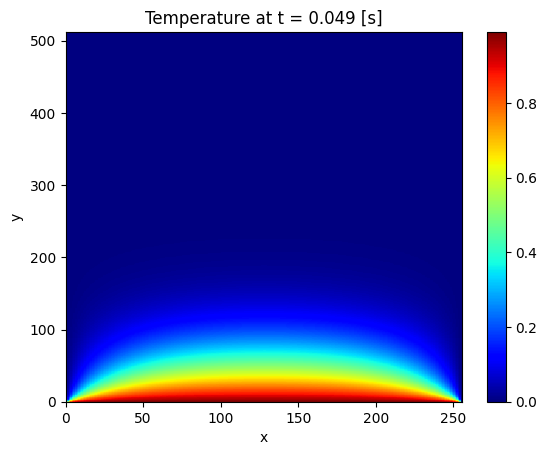

In [18]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -march=native -DNDEBUG -o heat solutions/exercise1.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

In [ ]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -march=native -DNDEBUG -o heat solutions/exercise1.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 2.7721 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 5.54421 GB/s
Plotting grid 512x256, t = 0.048828125


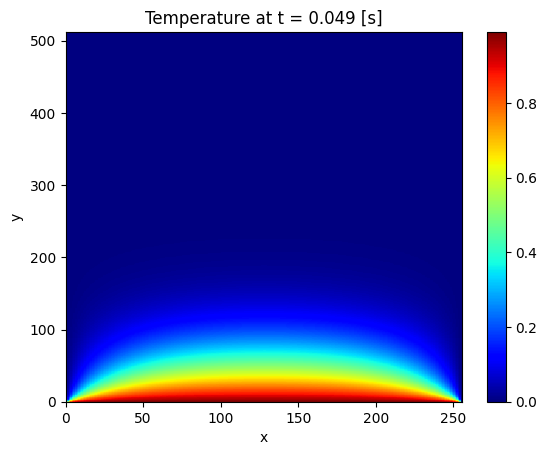

In [10]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -std=c++20 -stdpar=multicore -O4 -fast -march=native -Mllvm-fast -DNDEBUG -o heat solutions/exercise1.cpp
!mpirun -np 2 ./heat 256 256 16000
visualize()

When using `-stdpar=gpu`, nvc++ enables `-gpu=managed` by default to emulate Unified Memory on non-coherent platforms.

When combining this with MPI, we can tell UCX-based MPI implementations that Managed Memory used with MPI "mostly" resides on the device via the `UCX_RNDV_FRAG_MEM_TYPE=cuda` environment variable, which will force UCX to use device-pinned communication buffers instead of staging data communication via the host CPU:

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 2.5928 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 5.1856 GB/s
Plotting grid 512x256, t = 0.048828125


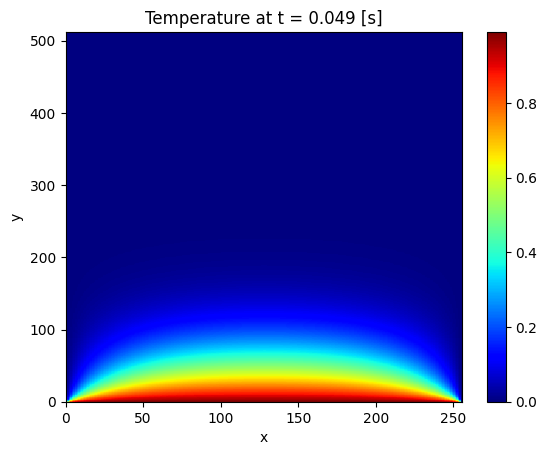

In [11]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -std=c++20 -stdpar=gpu -O4 -fast -march=native -Mllvm-fast -DNDEBUG -o heat solutions/exercise1.cpp
!UCX_RNDV_FRAG_MEM_TYPE=cuda mpirun -np 2 ./heat 256 256 16000
visualize()

## Exercise 2: Overlapping Communication and Computation

The goal of this exercise is to overlap communicaiton with computation using `std::thread`, `std::atomic`, and `std::barrier`.

A template for the solution is provided in [exercise2.cpp]. 
[exercise2.cpp]: ./exercise2.cpp

First, notice that the computation involves a data exchange with neighbors and is split into three steps:

* `internal`: processes internal rows that do not depend on data from neighbors
* `prev_boundary`: exchanges data with neighbor at `rank - 1` and processes the rows that depend on the elements received
* `next_boundary`: exchanges data with neighbor at `rank + 1` and processes the rows that depend on the elements received


```c++
double internal(double* u_new, double* u_old, parameters p) {
    grid g { .x_start = 2, .x_end = p.nx, .y_start = 1, .y_end = p.ny - 1 };
    energy += stencil(u_new.get(), u_old.get(), g, p);
}

double prev_boundary(double* u_new, double* u_old, parameters p) {
    // Send window cells, receive halo cells
    if (p.rank > 0) {
      // Send bottom boundary to bottom rank
      MPI_Send(u_old + p.ny, p.ny, MPI_DOUBLE, p.rank - 1, 0, MPI_COMM_WORLD);
      // Receive top boundary from bottom rank
      MPI_Recv(u_old + 0, p.ny,  MPI_DOUBLE, p.rank - 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    }
    grid g { .x_start = p.nx, .x_end = p.nx + 1, .y_start = 1, .y_end = p.ny - 1 };
    return stencil(u_new, u_old, g, p);
}

double next_boundary(double* u_new, double* u_old, parameters p) {
    if (p.rank < p.nranks - 1) {
        // Receive bottom boundary from top rank
        MPI_Recv(u_old + (p.nx + 1) * p.ny, p.ny, MPI_DOUBLE, p.rank + 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        // Send top boundary to top rank, and
        MPI_Send(u_old + p.nx * p.ny, p.ny, MPI_DOUBLE, p.rank + 1, 1, MPI_COMM_WORLD);
    }
    grid g { .x_start = 1, .x_end = 2, .y_start = 1, .y_end = p.ny - 1 };
    return stencil(u_new, u_old, g, p);
}
```

In the previous exercise, these steps are performed sequentially:

```c++
for (long it = 0; it < p.nit(); ++it) {
    double energy = 0.;
    // Exchange and compute domain boundaries:
    energy += prev_boundary(u_new.data(), u_old.data(), p);
    energy += next_boundary(u_new.data(), u_old.data(), p);
    energy += internal(u_new.data(), u_old.data(), p);
    // ...
}
```

In this exercise, we need to modify the application to perform these three steps concurrently and in parallel.

This will require:

* using one `std::thread` per computation in such a way that we do not launch one thread on every iteration
* using `std::atomic<double>` for the `energy`, to enable the separate threads to modify the energy concurrently
* using a `std::barrier` to synchronize the different threads

Furthermore, one of the threads will need to perform the following in a critical section:
  * `MPI_Reduce` of the `energy`: this operation requires for all threads to have updated the `energy` for the current iteration, so it must happen after these updates have completed
  * reset the `energy` to `0.` before the next iteration: all threads must wait for this operation to complete before starting the next iteration
  
The template [exercise2.cpp] provides `TODO`s to guide you through this process: 

```c++
  // TODO: use an atomic variable for the energy
  double energy = 0.;
    
  // TODO: use a barrier for synchronization
  // ...bar = ...

  // TODO: use threads for the different computations
  auto thread_prev = std::thread([/*TODO: complete capture */]() {
      for (long it = 0; it < p.nit(); ++it) {
          // TODO: perform the prev exchange and computation
          // TODO: update the atomic energy
          // TODO: synchronize with the barrier
      }
  });
    
  auto thread_next = /* TODO: similar for prev */;
      
  auto thread_internal = /*
    TODO: same as for next and prev
    TODO: need to perform the reduction in one of the threads (for example this one)
    TODO: need to reset the atomic in one of the threads (for example this one)
  */;

  // TODO: join all threads

```

[exercise2.cpp]: ./exercise2.cpp

### Compilation and run commands


The following commands compile but produce incorrect results.
Your goal is to fix that by following the instructions above.

Rank 0: local domain 256x256 (0.00104858 GB): 134357 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 268715 GB/s
E(t=0) = 12.528
E(t=0.00305176) = 0.00386456
E(t=0.00610352) = 0.00579684
E(t=0.00915527) = 0.00386456
E(t=0.012207) = 0.00386456
E(t=0.0152588) = 0.00386456
E(t=0.0183105) = 0.00386456
E(t=0.0213623) = 0.00579684
E(t=0.0244141) = 0.00386456
E(t=0.0274658) = 0.00579684
E(t=0.0305176) = 0.00386456
E(t=0.0335693) = 0.00579684
E(t=0.0366211) = 0.00386456
E(t=0.0396729) = 0.00386456
E(t=0.0427246) = 0.00386456
E(t=0.0457764) = 0.00386456
[hpcvis:1061 :0:1075] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x1)
[1667383805.049046] [hpcvis:1060 :0]       tag_match.c:62   UCX  WARN  unexpected tag-receive descriptor 0x7fcba3ffaf10 was not matched
terminate called without an active exception
[hpcvis:01060] *** Process received signal ***
[hpcvis:01060] Signal: Aborted (6)
[hpcvis:01060] Signal code:  (-6)
[hpcvis:01060] [ 0] /usr/lib/x86_64-linu

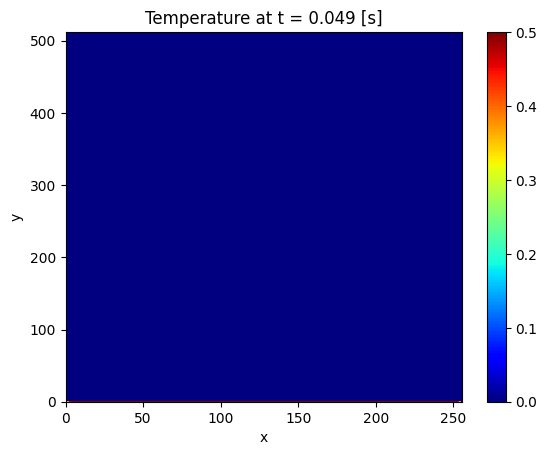

In [12]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -march=native -o heat exercise2.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

Rank 0: local domain 256x256 (0.00104858 GB): 77351.4 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 154703 GB/s
E(t=0) = 5.97173
[hpcvis:1128 :1:1138] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x556168378)
[1667383813.360789] [hpcvis:1128 :0]        spinlock.c:29   UCX  WARN  ucs_recursive_spinlock_destroy() failed: busy
[1667383813.367473] [hpcvis:1127 :0]       tag_match.c:62   UCX  WARN  unexpected tag-receive descriptor 0x7fbef2bf8e50 was not matched
terminate called without an active exception
[hpcvis:01127] *** Process received signal ***
[hpcvis:01127] Signal: Aborted (6)
[hpcvis:01127] Signal code:  (-6)
[hpcvis:01127] [ 0] /usr/lib/x86_64-linux-gnu/libc.so.6(+0x42520)[0x7fbf1d7f0520]
[hpcvis:01127] [ 1] /usr/lib/x86_64-linux-gnu/libc.so.6(pthread_kill+0x12c)[0x7fbf1d844a7c]
[hpcvis:01127] [ 2] /usr/lib/x86_64-linux-gnu/libc.so.6(raise+0x16)[0x7fbf1d7f0476]
[hpcvis:01127] [ 3] /usr/lib/x86_64-linux-gnu/libc.so.6(abort+0xd3)[0x7fbf1d7

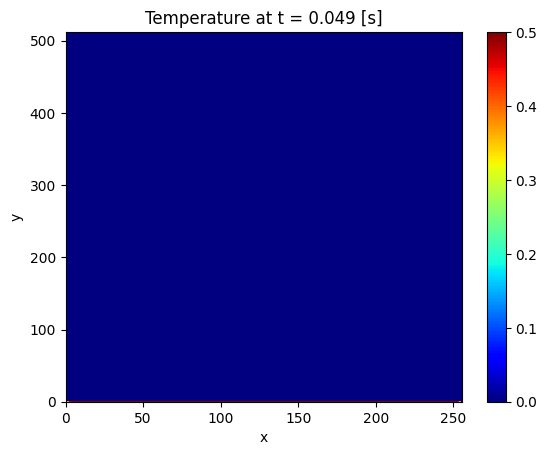

In [13]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -march=native -o heat exercise2.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

In [14]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -std=c++20 -stdpar=gpu -O4 -fast -march=native -Mllvm-fast -o heat exercise2.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

"exercise2.cpp", line 123: error: namespace "std" has no member "thread"
    std::thread thread_prev([p, u_new = u_new.data(), u_old = u_old.data(), 
         ^

"exercise2.cpp", line 137: error: namespace "std" has no member "thread"
    std::thread thread_next([p, u_new = u_new.data(), u_old = u_old.data(), 
         ^

"exercise2.cpp", line 143: error: namespace "std" has no member "thread"
    std::thread thread_inner([p, u_new = u_new.data(), u_old = u_old.data(),
         ^

3 errors detected in the compilation of "exercise2.cpp".
--------------------------------------------------------------------------
mpirun was unable to launch the specified application as it could not access
or execute an executable:

Executable: ./heat
Node: hpcvis

while attempting to start process rank 0.
--------------------------------------------------------------------------
2 total processes failed to start


FileNotFoundError: [Errno 2] No such file or directory: 'output'

### Solution Exercise 2

The solutions for each example are available in the `solutions/exercise2.cpp` sub-directory.

The following compiles and runs the solutions for Exercise 2 using different compilers and C++ standard versions.

rm: cannot remove 'output': No such file or directory
rm: cannot remove 'heat': No such file or directory
E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 5.66897 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 11.3379 GB/s
Plotting grid 512x256, t = 0.048828125


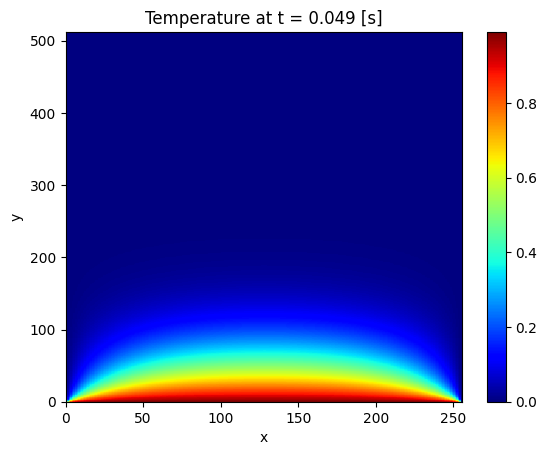

In [15]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -march=native -DNDEBUG -o heat solutions/exercise2.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 4.49881 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 8.99761 GB/s
Plotting grid 512x256, t = 0.048828125


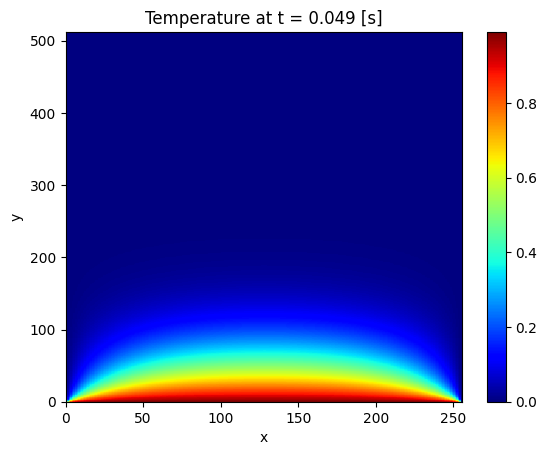

In [16]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -march=native -DNDEBUG -o heat solutions/exercise2.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

E(t=0) = 0.000775146
E(t=0.00305176) = 0.0563158
E(t=0.00610352) = 0.0781322
E(t=0.00915527) = 0.0939739
E(t=0.012207) = 0.106721
E(t=0.0152588) = 0.11749
E(t=0.0183105) = 0.126854
E(t=0.0213623) = 0.135153
E(t=0.0244141) = 0.142608
E(t=0.0274658) = 0.149375
E(t=0.0305176) = 0.155564
E(t=0.0335693) = 0.161261
E(t=0.0366211) = 0.166532
E(t=0.0396729) = 0.17143
E(t=0.0427246) = 0.175996
E(t=0.0457764) = 0.180266
Rank 0: local domain 256x256 (0.00104858 GB): 1.75843 GB/s
All ranks: global domain 512x256 (0.00209715 GB): 3.51686 GB/s
Plotting grid 512x256, t = 0.048828125


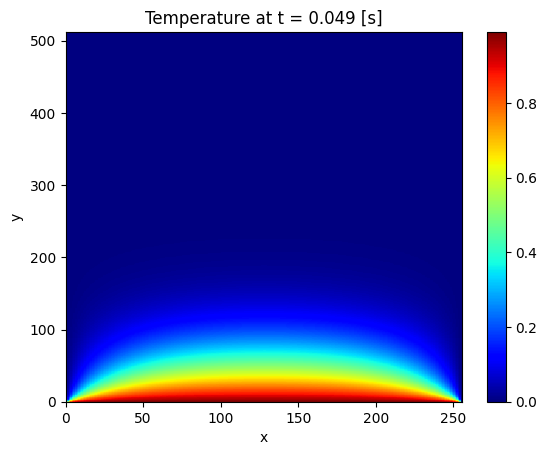

In [17]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -std=c++20 -stdpar=gpu -O4 -fast -march=native -Mllvm-fast -DNDEBUG -o heat solutions/exercise2.cpp
!mpirun -np 2 ./heat 256 256 16000
visualize()

## Exercise 3: Senders & Receivers

The goal of this exercise is to simplify the implementation of Exercise 2 - Overlap Communication and Computation - by using Senders & Receivers with a `static_thread_pool` to manage the host threads, while combining this with the C++ parallel algorithms.

The implementation of Exercise 2 is quite complex. It requires:

```c++
// A shared atomic variable to accumulate the energy:
std::atomic<double> energy = 0.;

// A shared barrier for synchronizing threads:
std::barrier bar(3);

// User must manually create and start threads:
std::thread thread_inner(..[&] {
      energy += computation(...);
      bar.arrive_and_wait();
      // User must manually create a critical section for MPI rank reduction: 
      MPI_Reduce(...);
      // User must manually reset the shared state on each iteration:
      energy = 0;
      bar.arrive_and_wait();
  });

std::thread thread_prev(...);
std::thread thread_next(...);

// User must manually join all threads before doing File I/O
thread_prev.join();
thread_next.join();
thread_inner.join();

// File I/O
```

In this exercise, we'll use Senders & Receivers instead to create a graph representing the computation:

```c++
stde::sender iteration_step(stde::scheduler sch, parameters p, long it,
                            std::vector<double>& u_new, std::vector<double>& u_old) {
    // TODO: use Senders & Receivers to create a graph representing the computation of a single iteration   
}
```

and will then dispatch it to an execution context:

```c++
stde::static_thread_pool ctx{3}; // Thread Pool with 3 threads
stde::scheduler auto sch = ctx.get_scheduler();

for (long it = 0; it < p.nit(); ++it) {
    stde::this_thread::sync_wait(iteration_step(sch));
}
```

### Compilation and run commands

[exercise3.cpp]: ./exercise3.cpp

The template [exercise3.cpp] compiles and runs as provided, but produces incorrect results due to the incomplete `iteration_step` implementation.

After completing it the following blocks should compile and run correctly:

### Solutions Exercise 3

The solutions for each example are available in the [`solutions/exercise3.cpp`] sub-directory.

[`solutions/exercise3.cpp`]: ./solutions/exercise3.cpp

The following blocks compiles and runs the solutions for Exercise 3 using different compilers and C++ standard versions.
By default, the [`static_thread_pool`] scheduler is used.

[`static_thread_pool`]: https://github.com/NVIDIA/stdexec/blob/main/include/exec/static_thread_pool.hpp

In [ ]:
!rm output || true
!rm heat || true
!OMPI_CXX=g++ mpicxx -std=c++20 -Ofast -march=native -DNDEBUG -o heat solutions/exercise3.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

In [ ]:
!rm output || true
!rm heat || true
!OMPI_CXX=clang++ mpicxx -std=c++20 -Ofast -march=native -DNDEBUG -o heat solutions/exercise3.cpp -ltbb
!mpirun -np 2 ./heat 256 256 16000
visualize()

In [ ]:
!rm output || true
!rm heat || true
!OMPI_CXX=nvc++ mpicxx -std=c++20 -stdpar=gpu -O4 -fast -march=native -Mllvm-fast -DNDEBUG -o heat solutions/exercise3.cpp
!mpirun -np 2 ./heat 256 256 16000
visualize()